In [1]:
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
from sklearn.model_selection import train_test_split
from calendar import monthrange
import os, json
from rasterstats import zonal_stats
import rasterio
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
base_p = os.getcwd()
print(base_p)
if base_p != "/home/sergei/Downloads/vkr/trying_rnn/code":
    raise Exception()
else:
    print("Path", base_p)

/home/sergei/Downloads/vkr/trying_rnn/code
Path /home/sergei/Downloads/vkr/trying_rnn/code


In [3]:
# load datasets
project_files = base_p + "/project_data/"
fires_path = project_files + "fires_with_factors/"
years = list(range(2015, 2025))
print(
    "Paths:", project_files, fires_path,
    "Years:", years, sep="\n"
)

fires_ds_l = []
for year_ in years:
    fires_geojson_path = fires_path + f"factor_dataset_{str(year_)}.geojson"
    ds = gpd.read_file(fires_geojson_path)
    fires_ds_l.append(ds)
print(f"Imported {len(fires_ds_l)} datasets")

Paths:
/home/sergei/Downloads/vkr/trying_rnn/code/project_data/
/home/sergei/Downloads/vkr/trying_rnn/code/project_data/fires_with_factors/
Years:
[2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
Imported 10 datasets


In [4]:
# print the first dataset as an example
print(
    "Shape:", fires_ds_l[0].shape, "Columns:", fires_ds_l[0].dtypes, 
    "(Non)fire ratio:", fires_ds_l[0].is_fire.value_counts(), sep="\n"
)
print("Nan values:\n", fires_ds_l[0].isnull().sum())
pd.options.display.max_columns = None   # show all columns
fires_ds_l[0].head(5)

Shape:
(2755, 52)
Columns:
year                        int32
lat                       float64
lon                       float64
event_date         datetime64[ms]
is_fire                     int32
grid_lat                  float64
grid_lon                  float64
soilw40_mean              float64
soilw40_std               float64
soilw200_mean             float64
soilw200_std              float64
tmin_mean                 float64
tmin_std                  float64
snod_mean                 float64
snod_std                  float64
tmpgr40_mean              float64
tmpgr40_std               float64
t_mean                    float64
t_std                     float64
wind_speed_mean           float64
wind_speed_std            float64
tmpgr100_mean             float64
tmpgr100_std              float64
tmpgr10_mean              float64
tmpgr10_std               float64
tmax_mean                 float64
tmax_std                  float64
rh_mean                   float64
rh_std               

,year,lat,lon,event_date,is_fire,grid_lat,grid_lon,soilw40_mean,soilw40_std,soilw200_mean,soilw200_std,tmin_mean,tmin_std,snod_mean,snod_std,tmpgr40_mean,tmpgr40_std,t_mean,t_std,wind_speed_mean,wind_speed_std,tmpgr100_mean,tmpgr100_std,tmpgr10_mean,tmpgr10_std,tmax_mean,tmax_std,rh_mean,rh_std,apcp_mean,apcp_std,wind_dir_mean,wind_dir_std,tmpgr200_mean,tmpgr200_std,soilw10_mean,soilw10_std,soilw100_mean,soilw100_std,elevation,slope,aspect,vegetation_type,road_type,road_id,road_dist,river_id,river_dist,locality_type,locality_id,locality_dist,geometry
0,2015,60.0217,115.8679,2015-07-16,1,60.0,116.0,0.2500,0.000000,0.43,0.0,14.6125,3.716157,0.000,0.000000,6.13875,0.101198,18.23750,6.117966,1.5125,0.530330,0.56875,0.031368,15.25375,1.268542,20.3250,5.414201,66.8125,24.911067,0.8000,1.729575,2.8250,125.600862,-3.61375,0.023867,0.26375,0.005175,0.27000,0.000000,756.285714,3.867853,171.964294,21.0,прочая,152,193759.177102,228,21785.981741,село сельский,05.���,114105.573893,"POLYGON ((12897309.459 8403569.034, 12897309.1..."
1,2015,59.7178,115.0410,2015-08-06,1,59.5,115.0,0.2600,0.000000,0.44,0.0,14.0375,1.972625,0.000,0.000000,7.23875,0.226932,16.96875,4.892725,1.3125,0.360307,3.32625,0.062321,14.44875,1.495502,19.3500,4.422023,64.4375,18.171008,0.5625,0.954594,69.8375,98.871431,-2.31000,0.036253,0.20375,0.005175,0.28000,0.000000,794.625000,4.589434,194.938690,1.0,прочая,152,231036.127592,219,23197.616858,село сельский,05.���,219916.158194,"POLYGON ((12805346.404 8336204.874, 12805346.1..."
2,2015,59.5761,113.9840,2015-09-25,1,59.5,114.0,0.3475,0.004629,0.45,0.0,-0.6500,1.229402,0.001,0.001604,1.11125,0.054625,1.69125,4.611679,1.9500,0.272554,1.30125,0.106159,1.09500,0.702058,4.6250,4.451244,89.4375,13.782902,0.0125,0.035355,43.5125,156.324447,-0.37875,0.006409,0.32375,0.005175,0.33000,0.000000,511.181818,7.200536,15.219467,11.0,прочая,152,281283.822800,220,1721.018231,село сельский,17.���,182717.515536,"POLYGON ((12687257.185 8304795.856, 12687256.7..."
3,2015,59.4877,113.6689,2015-09-24,1,59.5,113.5,0.3400,0.000000,0.43,0.0,0.1125,1.782805,0.000,0.000000,1.58125,0.084758,2.42125,4.508691,2.5000,0.565685,1.69000,0.119284,1.16250,0.824686,5.0125,4.376704,83.8000,13.372894,0.2125,0.601041,-74.2375,153.426119,-0.37625,0.005175,0.31875,0.003536,0.31000,0.000000,512.181818,2.837777,7.961754,15.0,прочая,152,312789.373320,220,25686.184906,село сельский,17.���,142391.828552,"POLYGON ((12653525.898 8287187.746, 12653525.7..."
4,2015,59.3922,114.0660,2015-07-12,1,59.5,114.0,0.3000,0.000000,0.45,0.0,12.9625,4.816916,0.000,0.000000,5.59500,0.149188,17.49625,6.516379,1.7875,1.098619,0.49250,0.014880,12.95125,1.454495,20.3125,3.562679,64.0375,18.604603,0.3875,1.017613,-9.7000,100.407783,-2.68000,0.020000,0.23000,0.000000,0.34875,0.003536,899.625000,5.854614,201.392883,1.0,прочая,152,316608.671509,220,15611.137720,поселок сельский,05.���,158680.082953,"POLYGON ((12696710.022 8264660.54, 12696709.73..."


In [5]:
# concatenate datasets
fires_dataset = pd.concat(fires_ds_l, ignore_index=True)
fires_dataset = fires_dataset.sort_values(by="event_date")
print("Shape:", fires_dataset.shape, 
      "Columns:", fires_dataset.dtypes,
      "(Non)fires ratio:", fires_dataset.is_fire.value_counts(), sep="\n"
)
print("Nan values:", fires_dataset.isnull().sum(), sep="\n")

Shape:
(19864, 52)
Columns:
year                        int32
lat                       float64
lon                       float64
event_date         datetime64[ms]
is_fire                     int32
grid_lat                  float64
grid_lon                  float64
soilw40_mean              float64
soilw40_std               float64
soilw200_mean             float64
soilw200_std              float64
tmin_mean                 float64
tmin_std                  float64
snod_mean                 float64
snod_std                  float64
tmpgr40_mean              float64
tmpgr40_std               float64
t_mean                    float64
t_std                     float64
wind_speed_mean           float64
wind_speed_std            float64
tmpgr100_mean             float64
tmpgr100_std              float64
tmpgr10_mean              float64
tmpgr10_std               float64
tmax_mean                 float64
tmax_std                  float64
rh_mean                   float64
rh_std              

In [6]:
fires_dataset.head(5)

,year,lat,lon,event_date,is_fire,grid_lat,grid_lon,soilw40_mean,soilw40_std,soilw200_mean,soilw200_std,tmin_mean,tmin_std,snod_mean,snod_std,tmpgr40_mean,tmpgr40_std,t_mean,t_std,wind_speed_mean,wind_speed_std,tmpgr100_mean,tmpgr100_std,tmpgr10_mean,tmpgr10_std,tmax_mean,tmax_std,rh_mean,rh_std,apcp_mean,apcp_std,wind_dir_mean,wind_dir_std,tmpgr200_mean,tmpgr200_std,soilw10_mean,soilw10_std,soilw100_mean,soilw100_std,elevation,slope,aspect,vegetation_type,road_type,road_id,road_dist,river_id,river_dist,locality_type,locality_id,locality_dist,geometry
1526,2015,58.663880,115.045480,2015-03-01,0,58.5,115.0,0.34,0.0,0.45,0.0,-16.4625,3.700555,1.130250,0.022308,-5.43750,0.004629,-15.14375,3.590845,2.2875,1.180118,-4.83500,0.011952,-7.83625,0.121530,-13.0625,1.953705,98.7000,1.104536,0.5125,0.164208,34.7000,42.018669,-4.04125,0.021671,0.44,0.0,0.30,0.0,1009.0,2.623352,68.385223,18.0,прочая,150,197998.018269,220,22715.680095,рабочий поселок городской,05.���,43092.042780,POINT (12806804.235 8108090.34)
2185,2015,58.194789,108.761033,2015-03-01,0,58.0,109.0,0.34,0.0,0.39,0.0,-14.0500,7.859117,0.372000,0.022162,-4.36375,0.014079,-13.58625,8.132116,3.8375,1.312509,-2.67250,0.042678,-7.89750,0.412994,-10.6625,6.178751,98.8750,0.770436,1.0125,0.693722,29.7000,37.151735,-0.85625,0.014079,0.43,0.0,0.33,0.0,343.0,5.293030,271.118408,15.0,прочая,162,416592.960307,276,16471.904869,поселок сельский,15.44,15807.099098,POINT (12107222.856 8008348.484)
2057,2015,58.060256,110.387262,2015-03-01,0,58.0,110.5,0.34,0.0,0.41,0.0,-14.4625,6.831218,0.368500,0.012224,-5.77500,0.026186,-13.99250,7.089803,3.7875,0.697828,-4.14875,0.050551,-8.78250,0.381828,-11.1500,4.417174,98.1375,1.166114,0.6000,0.400000,33.2625,41.242833,-2.21125,0.027484,0.41,0.0,0.30,0.0,468.0,0.507047,230.527542,11.0,прочая,150,421886.502737,280,43492.051132,село сельский,15.25,97132.569650,POINT (12288253.824 7979986.183)
2244,2015,55.410460,103.593171,2015-03-01,0,55.5,103.5,0.35,0.0,0.28,0.0,-10.3625,3.769023,0.354875,0.016496,-4.74250,0.004629,-9.62750,4.043534,3.5500,0.486973,-3.27750,0.025495,-8.07375,0.459594,-8.1000,2.993803,99.2625,0.504090,0.9375,0.620915,-2.9000,42.869803,-0.99000,0.020000,0.46,0.0,0.30,0.0,617.0,1.123697,133.339722,11.0,прочая,186,191220.661141,404,23823.907428,поселок сельский,���.56,43067.645358,POINT (11531939.076 7441938.961)
1543,2015,60.964031,106.180778,2015-03-01,0,61.0,106.0,0.29,0.0,0.33,0.0,-19.0500,8.210794,0.771250,0.034363,-6.30625,0.007440,-18.38625,8.820781,3.2500,1.323415,-5.51875,0.009910,-8.48375,0.118314,-14.8875,7.387139,99.0375,0.547560,0.8750,0.909867,-10.1125,78.523253,-4.34875,0.025319,0.35,0.0,0.28,0.0,415.0,0.683370,147.380753,18.0,прочая,173,760352.149794,215,21518.327357,Деревня сельский,13.13,57837.791872,POINT (11819990.086 8617568.749)


0.5805980668546113 0.41940193314538865


<Axes: xlabel='Класс', ylabel='Количество'>

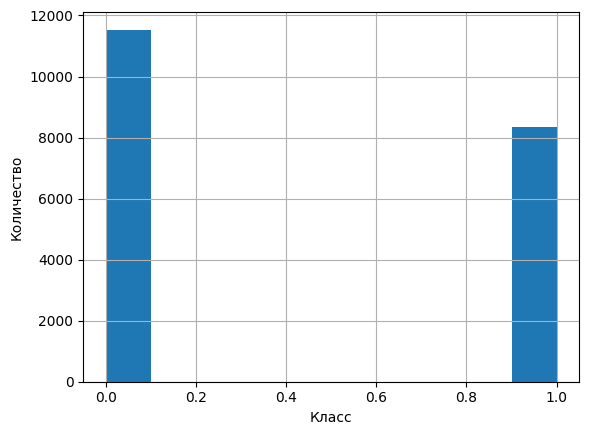

In [7]:
vc = fires_dataset.is_fire.value_counts()
print(vc[0] / fires_dataset.shape[0], vc[1] / fires_dataset.shape[0])
plt.xlabel("Класс")
plt.ylabel("Количество")
fires_dataset.is_fire.hist()

In [8]:
# what are some basic steps to do before training
# clean data:
# deal with the missing values (done), outliers (the z-score normalization) (not done)
# and inconsistencies (wrong naming or metrics, for ex, convert currencies to one unit or 
# word capitalization) (done)

# transform data:
# normalize data () or standardize it (use z-score ((a - mean) / std_dev) - read about the difference
# scale data (put it in a certain range)
# convert categorical data to numerical

# feature creation (create the new informative feature from the multiple existing)

# carefull with chronological order so that the past data doesn't leak to the test dataset

# reduce data
# dimensionality reduction (get rid of the data without losing information) - for ex, PCA

# balance the data (for ex, if fires are much more than non-fires)

# split data (the data should be balanced in both datasets)

# repeat the same operations for the test data (if you did it after splitting)
#

# Methods:
# z-score normalizatioin centers data distribution around 0, min-max scaling bounds values
# within specific range



# https://www.knime.com/blog/four-basic-steps-in-data-preparation
# https://www.knime.com/blog/seven-techniques-for-data-dimensionality-reduction
# https://www.pecan.ai/blog/data-preparation-for-machine-learning/
# https://lakefs.io/blog/machine-learning-data-preparation/
# https://www.techtarget.com/searchbusinessanalytics/feature/Data-preparation-in-machine-learning-6-key-steps
# https://www.datastax.com/guides/how-to-prepare-data-for-ai
# https://www.phdata.io/blog/how-to-prepare-data-for-use-in-machine-learning-models/
# https://www.researchgate.net/post/Do_we_need_to_standardize_variables_with_different_scales_before_doing_correlation_analysis
# 



In [9]:
# save 2024 year as the test dataset before working with the features
exclude_cols_test = [
    # "event_date",
    "lat", "lon", "grid_lat", "grid_lon", "road_type", "road_id", 
    "river_id", "locality_id", "locality_type", "techno_obj_id", "geometry", 
]
test_ds = fires_dataset[fires_dataset.year == 2024]
test_ds = test_ds.loc[:, ~test_ds.columns.isin(exclude_cols_test)]
# write file
write_path = project_files + "train_data/"
if not os.path.exists(write_path):
    os.mkdir(write_path)
test_ds.to_csv(write_path + "test_dataset_2024.csv", sep=";")
print(test_ds.index, test_ds.shape)
test_ds.head(5)

Index([19315, 19104, 19806, 19779, 19562, 19532, 19527, 19154, 19674, 19351,
       ...
       19352, 19363, 19791, 19373, 19427, 19471, 19489, 19514, 18989, 19063],
      dtype='int64', length=1556) (1556, 42)


,year,event_date,is_fire,soilw40_mean,soilw40_std,soilw200_mean,soilw200_std,tmin_mean,tmin_std,snod_mean,snod_std,tmpgr40_mean,tmpgr40_std,t_mean,t_std,wind_speed_mean,wind_speed_std,tmpgr100_mean,tmpgr100_std,tmpgr10_mean,tmpgr10_std,tmax_mean,tmax_std,rh_mean,rh_std,apcp_mean,apcp_std,wind_dir_mean,wind_dir_std,tmpgr200_mean,tmpgr200_std,soilw10_mean,soilw10_std,soilw100_mean,soilw100_std,elevation,slope,aspect,vegetation_type,road_dist,river_dist,locality_dist
19315,2024,2024-03-01,0,0.34,0.0,0.46,0.0,-19.0125,2.390121,0.134250,0.063637,-13.50750,0.161665,-16.84000,3.466192,3.7250,0.976510,-10.88125,0.039799,-15.84125,0.909701,-15.4125,3.544588,94.4250,5.893519,0.1875,0.188509,49.6250,11.694046,-7.11250,0.065846,0.38,0.0,0.33,0.0,2214.0,13.906085,39.996078,21.0,279246.134278,12763.348115,27921.440441
19104,2024,2024-03-01,0,0.36,0.0,0.38,0.0,-13.5875,3.853176,0.129375,0.057815,-9.75625,0.195809,-11.04500,3.948273,2.4125,0.771710,-7.10500,0.031623,-11.38000,1.337375,-9.0500,3.893584,95.0625,4.987968,0.2750,0.377018,24.7000,40.659000,-2.97000,0.077828,0.42,0.0,0.35,0.0,849.0,6.824051,282.706177,18.0,72010.297452,8816.743841,21366.124105
19806,2024,2024-03-01,0,0.35,0.0,0.44,0.0,-14.4875,1.962096,0.178625,0.131081,-11.41625,0.195371,-13.22000,2.558102,3.2625,1.377303,-9.71125,0.037583,-13.40625,1.077456,-12.2000,2.337887,96.4875,3.452303,0.4750,0.205287,42.0500,51.821397,-7.54250,0.042678,0.42,0.0,0.32,0.0,472.0,0.633459,199.093491,18.0,665535.090753,22987.812032,86292.492518
19779,2024,2024-03-01,0,0.35,0.0,0.38,0.0,-15.2875,6.186492,0.143625,0.068802,-12.90125,0.147303,-13.00250,5.935226,2.6875,1.037080,-11.07875,0.037583,-14.45000,1.254455,-11.5625,4.708636,97.1500,3.878144,0.5625,0.565528,52.6625,48.279867,-8.05625,0.052082,0.41,0.0,0.30,0.0,784.0,4.401981,58.882362,18.0,44680.049751,8541.776895,45273.988857
19562,2024,2024-03-01,0,0.36,0.0,0.41,0.0,-14.2125,4.077267,0.140625,0.072981,-9.07375,0.156291,-11.69125,4.031013,2.5000,0.754037,-6.65750,0.029641,-11.44750,1.220407,-10.0375,4.002477,95.6500,4.740404,0.3625,0.480885,33.8875,37.660037,-3.13750,0.060651,0.40,0.0,0.35,0.0,884.0,3.040766,275.861542,17.0,143938.399536,7520.180463,79470.921820


In [10]:
vc = test_ds.is_fire.value_counts()
print(vc[0]/test_ds.shape[0], vc[1]/test_ds.shape[0])
vc[0], vc[1]

0.5681233933161953 0.4318766066838046


(884, 672)

In [11]:
exclude_cols = [
    # "event_date", 
    "lat", "lon", "grid_lat", "grid_lon", "road_type", "road_id", 
    "river_id", "locality_id", "locality_type", "techno_obj_id", "geometry", "year"
]
# exlude 2024 year
train_dataset = fires_dataset[fires_dataset.year != 2024]
print(fires_dataset.shape, train_dataset[train_dataset.year == 2024].shape,)
print("Duplicates:", train_dataset.index.duplicated().sum().sum())

train_dataset.reset_index(drop=True, inplace=True)
print(train_dataset.index)

train_dataset = train_dataset.loc[:, ~(train_dataset.columns.isin(exclude_cols))].round(decimals=6)
train_dataset["vegetation_type"] = train_dataset["vegetation_type"].astype(int)
print(train_dataset.shape, train_dataset.shape[0] - fires_dataset.shape[0], train_dataset.dtypes, sep="\n")
train_dataset.head(5)

(19864, 52) (0, 52)
Duplicates: 0
RangeIndex(start=0, stop=18308, step=1)
(18308, 41)
-1556
event_date         datetime64[ms]
is_fire                     int32
soilw40_mean              float64
soilw40_std               float64
soilw200_mean             float64
soilw200_std              float64
tmin_mean                 float64
tmin_std                  float64
snod_mean                 float64
snod_std                  float64
tmpgr40_mean              float64
tmpgr40_std               float64
t_mean                    float64
t_std                     float64
wind_speed_mean           float64
wind_speed_std            float64
tmpgr100_mean             float64
tmpgr100_std              float64
tmpgr10_mean              float64
tmpgr10_std               float64
tmax_mean                 float64
tmax_std                  float64
rh_mean                   float64
rh_std                    float64
apcp_mean                 float64
apcp_std                  float64
wind_dir_mean           

,event_date,is_fire,soilw40_mean,soilw40_std,soilw200_mean,soilw200_std,tmin_mean,tmin_std,snod_mean,snod_std,tmpgr40_mean,tmpgr40_std,t_mean,t_std,wind_speed_mean,wind_speed_std,tmpgr100_mean,tmpgr100_std,tmpgr10_mean,tmpgr10_std,tmax_mean,tmax_std,rh_mean,rh_std,apcp_mean,apcp_std,wind_dir_mean,wind_dir_std,tmpgr200_mean,tmpgr200_std,soilw10_mean,soilw10_std,soilw100_mean,soilw100_std,elevation,slope,aspect,vegetation_type,road_dist,river_dist,locality_dist
0,2015-03-01,0,0.34,0.0,0.45,0.0,-16.4625,3.700555,1.130250,0.022308,-5.43750,0.004629,-15.14375,3.590845,2.2875,1.180118,-4.83500,0.011952,-7.83625,0.121530,-13.0625,1.953705,98.7000,1.104536,0.5125,0.164208,34.7000,42.018669,-4.04125,0.021671,0.44,0.0,0.30,0.0,1009.0,2.623352,68.385223,18,197998.018269,22715.680095,43092.042780
1,2015-03-01,0,0.34,0.0,0.39,0.0,-14.0500,7.859117,0.372000,0.022162,-4.36375,0.014079,-13.58625,8.132116,3.8375,1.312509,-2.67250,0.042678,-7.89750,0.412994,-10.6625,6.178751,98.8750,0.770436,1.0125,0.693722,29.7000,37.151735,-0.85625,0.014079,0.43,0.0,0.33,0.0,343.0,5.293030,271.118408,15,416592.960307,16471.904869,15807.099098
2,2015-03-01,0,0.34,0.0,0.41,0.0,-14.4625,6.831218,0.368500,0.012224,-5.77500,0.026186,-13.99250,7.089803,3.7875,0.697828,-4.14875,0.050551,-8.78250,0.381828,-11.1500,4.417174,98.1375,1.166114,0.6000,0.400000,33.2625,41.242833,-2.21125,0.027484,0.41,0.0,0.30,0.0,468.0,0.507047,230.527542,11,421886.502737,43492.051132,97132.569650
3,2015-03-01,0,0.35,0.0,0.28,0.0,-10.3625,3.769023,0.354875,0.016496,-4.74250,0.004629,-9.62750,4.043534,3.5500,0.486973,-3.27750,0.025495,-8.07375,0.459594,-8.1000,2.993803,99.2625,0.504090,0.9375,0.620915,-2.9000,42.869803,-0.99000,0.020000,0.46,0.0,0.30,0.0,617.0,1.123697,133.339722,11,191220.661141,23823.907428,43067.645358
4,2015-03-01,0,0.29,0.0,0.33,0.0,-19.0500,8.210794,0.771250,0.034363,-6.30625,0.007440,-18.38625,8.820781,3.2500,1.323415,-5.51875,0.009910,-8.48375,0.118314,-14.8875,7.387139,99.0375,0.547560,0.8750,0.909867,-10.1125,78.523253,-4.34875,0.025319,0.35,0.0,0.28,0.0,415.0,0.683370,147.380753,18,760352.149794,21518.327357,57837.791872


<Axes: >

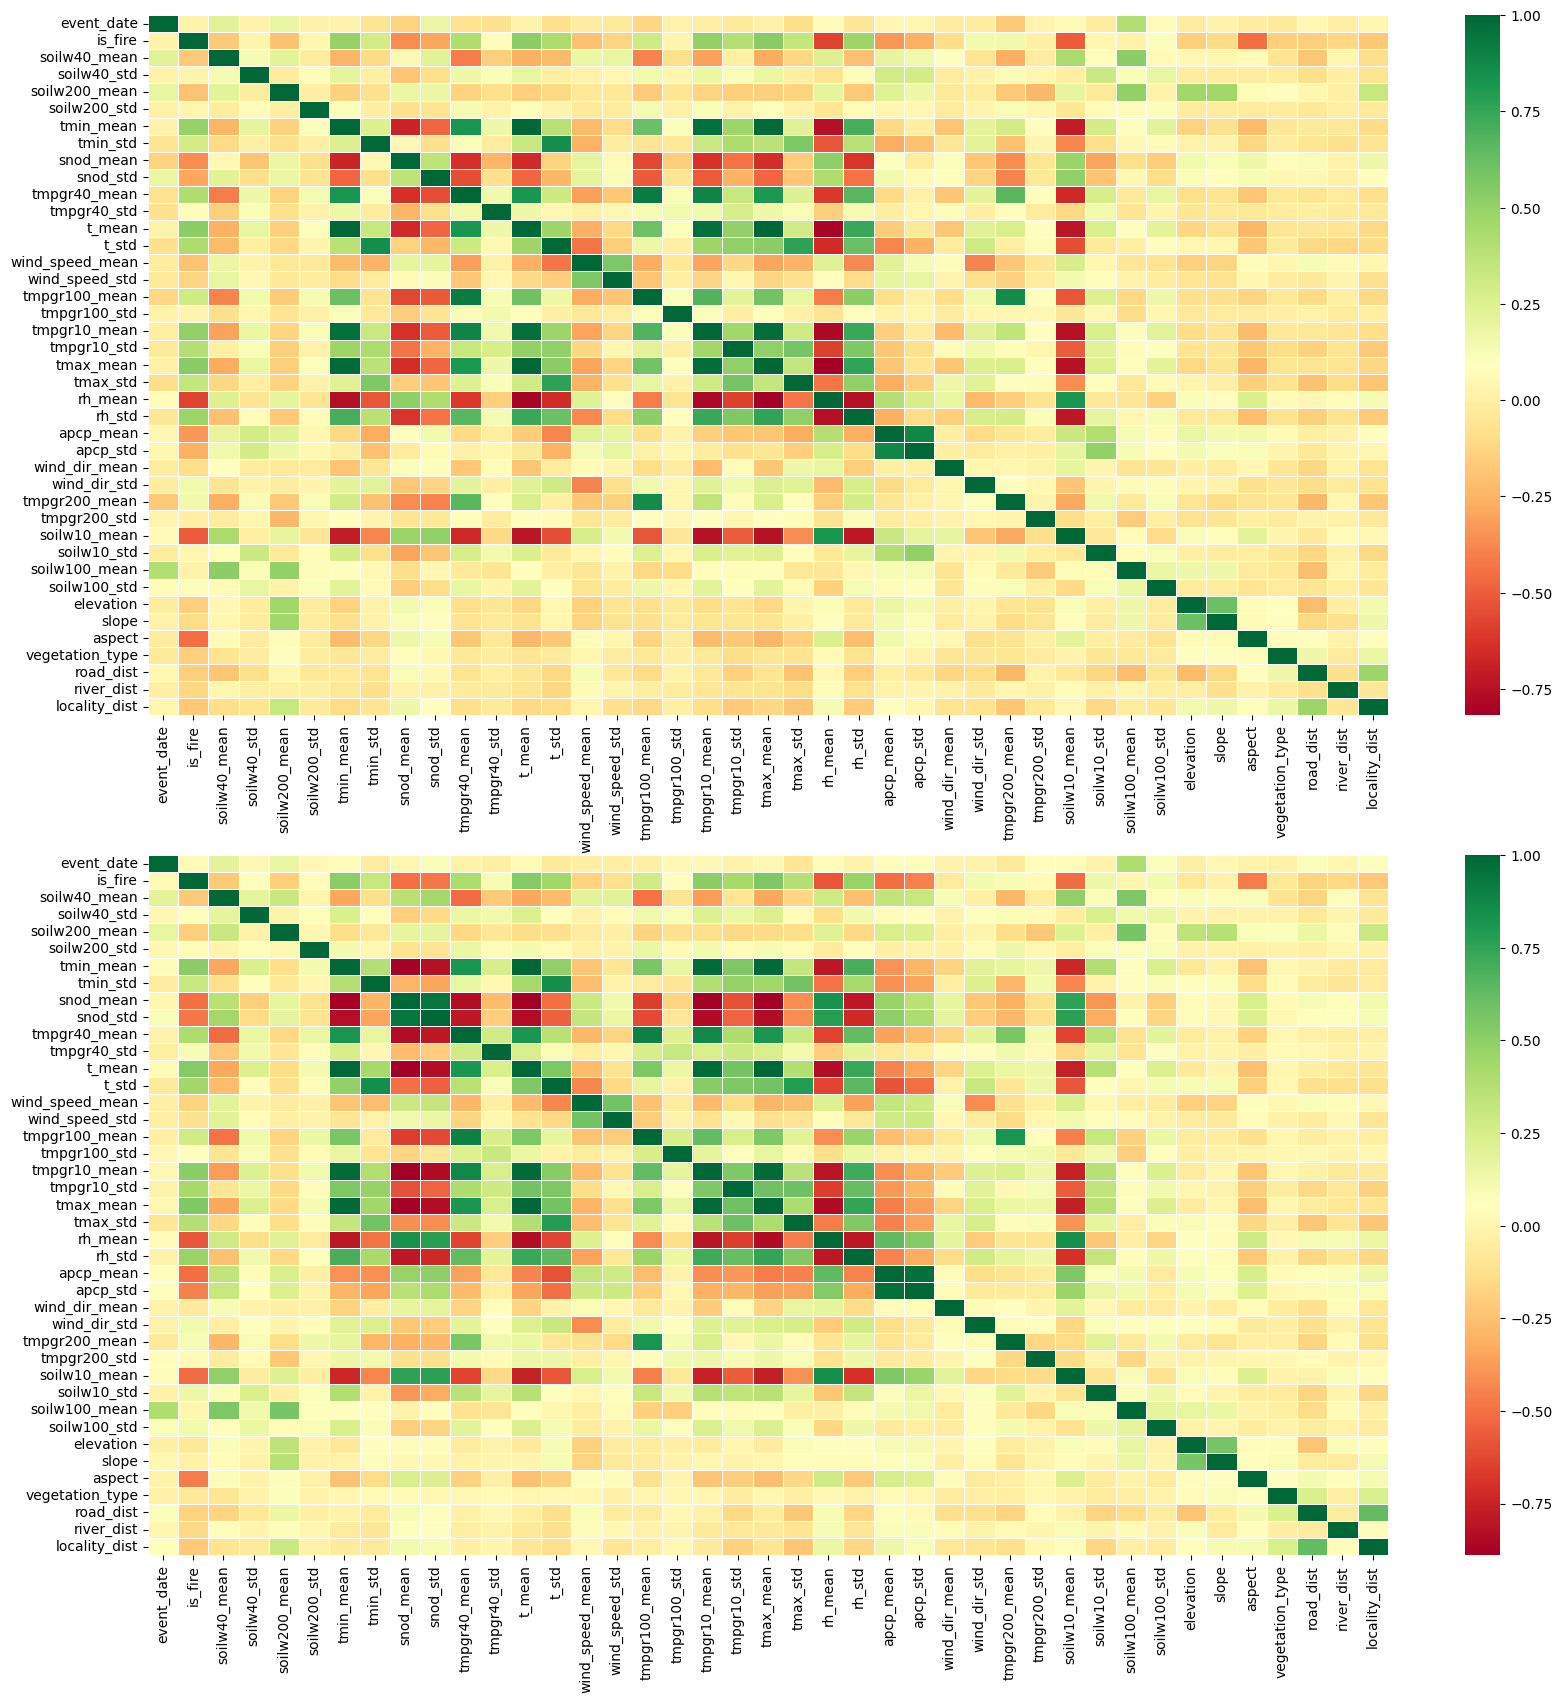

In [12]:
fig = plt.figure(figsize=(20, 20))
ax = fig.subplots(2, 1)
pr = train_dataset.corr(method="pearson")
sp = train_dataset.corr(method="spearman")
# pr.loc[["WIND_DIR_STD", "WIND_SPEED"], :]
# sp.loc[["WIND_DIR_STD", "WIND_SPEED"], :]
sns.heatmap(pr, linewidths=0.5, fmt=".2f", ax=ax[0], cmap='RdYlGn',) #annot=True, )
sns.heatmap(sp,linewidths=0.5, fmt=".2f", ax=ax[1], cmap='RdYlGn',)  #annot=True, 

In [13]:
base_factors = [
    "apcp_mean", "rh_mean",
    "t_mean", "wind_speed_mean", "wind_dir_std", "aspect",
    "elevation", "slope", "locality_dist", "river_dist", "road_dist",
    "vegetation_type",
]
include_factors = base_factors + [
    "soilw10_mean", "event_date", "is_fire"
]
print(len(include_factors), include_factors,)

15 ['apcp_mean', 'rh_mean', 't_mean', 'wind_speed_mean', 'wind_dir_std', 'aspect', 'elevation', 'slope', 'locality_dist', 'river_dist', 'road_dist', 'vegetation_type', 'soilw10_mean', 'event_date', 'is_fire']


In [14]:
train_dataset = train_dataset.loc[:, train_dataset.columns.isin(include_factors)]
train_dataset.columns

Index(['event_date', 'is_fire', 't_mean', 'wind_speed_mean', 'rh_mean',
       'apcp_mean', 'wind_dir_std', 'soilw10_mean', 'elevation', 'slope',
       'aspect', 'vegetation_type', 'road_dist', 'river_dist',
       'locality_dist'],
      dtype='object')

In [15]:
# standardize using z-score only numeical variables (without the target and the categorical variable)
ex_cols = ["vegetation_type", "is_fire", "event_date"]
train_ds_ = train_dataset.loc[:, ~train_dataset.columns.isin(ex_cols)]
train_ds_ = (train_ds_ - train_ds_.mean()) / train_ds_.std()
train_ds = train_ds_.join(train_dataset["is_fire"])
print(train_ds.columns, train_ds.index, sep="\n")
pd.options.display.float_format = '{:.2f}'.format
train_ds.describe()

Index(['t_mean', 'wind_speed_mean', 'rh_mean', 'apcp_mean', 'wind_dir_std',
       'soilw10_mean', 'elevation', 'slope', 'aspect', 'road_dist',
       'river_dist', 'locality_dist', 'is_fire'],
      dtype='object')
RangeIndex(start=0, stop=18308, step=1)


,t_mean,wind_speed_mean,rh_mean,apcp_mean,wind_dir_std,soilw10_mean,elevation,slope,aspect,road_dist,river_dist,locality_dist,is_fire
count,18308.00,18308.00,18308.00,18308.00,18308.00,18308.00,18308.00,18308.00,18308.00,18308.00,18308.00,18308.00,18308.00
mean,0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.42
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.49
min,-3.81,-2.04,-2.46,-0.62,-1.55,-1.79,-1.57,-0.97,-1.21,-1.04,-1.10,-1.10,0.00
25%,-0.73,-0.72,-0.87,-0.62,-0.82,-0.87,-0.65,-0.63,-0.90,-0.80,-0.75,-0.81,0.00
50%,0.05,-0.18,0.17,-0.38,-0.23,-0.09,-0.29,-0.36,-0.23,-0.37,-0.23,-0.28,0.00
75%,0.88,0.54,0.98,0.21,0.73,0.71,0.39,0.28,0.83,0.57,0.47,0.53,1.00
max,2.14,4.96,1.27,12.55,4.48,1.88,7.06,8.73,2.11,3.00,6.15,4.21,1.00


In [16]:
# pearson correlation with pvalue (using train_ds)
# train_ds = train_dataset.loc[:, ~train_dataset.columns.isin(["vegetation_type", "year"])]
pearson_corr_d = {}
moderate_pearson_corr_d = {}
strong_pearson_corr_d = {}
for i in range(train_ds.shape[1]):
    col = train_ds.iloc[:, i]
    # print(f"Checking column {col.name}")
    pearson_corr_d[col.name] = {}
    moderate_pearson_corr_d[col.name] = {}
    strong_pearson_corr_d[col.name] = {}
    for j in range(train_ds.shape[1]):
        col_ = train_ds.iloc[:, j]
        r, p_value = st.pearsonr(col, col_)
        # print(f"{col.name} {col_.name} Coeff: {r}, p_value: {p_value}")
        if p_value < 0.05:
            # print("Correlation exists")
            pearson_corr_d[col.name][col_.name] = r
            if 0.3 <= abs(r) < 0.5:
                moderate_pearson_corr_d[col.name][col_.name] = r
            elif abs(r) >= 0.5:
                strong_pearson_corr_d[col.name][col_.name] = r
        else:
            # print("Correlation doesn't exist")
            pass
    # print("\n")
# print(
#     "All",
#     json.dumps(pearson_corr_d, indent=4), 
#     "Moderate:",
#     json.dumps(moderate_pearson_corr_d, indent=4),
#     "Strong:",
#     json.dumps(strong_pearson_corr_d, indent=4),
#     sep="\n"
# )

In [17]:
# spearman correlation with pvalue (using train_ds)
# train_ds = train_dataset.loc[:, ~train_dataset.columns.isin(["vegetation_type", "year"])]
spearman_corr_d = {}
moderate_spearman_corr_d = {}
strong_spearman_corr_d = {}
for i in range(train_ds.shape[1]):
    col = train_ds.iloc[:, i]
    # print(f"Checking column {col.name}")
    spearman_corr_d[col.name] = {}
    moderate_spearman_corr_d[col.name] = {}
    strong_spearman_corr_d[col.name] = {}
    for j in range(train_ds.shape[1]):
        col_ = train_ds.iloc[:, j]
        r, p_value = st.spearmanr(col, col_)
        # print(f"{col.name} {col_.name} Coeff: {r}, p_value: {p_value}")
        if p_value < 0.05:
            # print("Correlation exists")
            spearman_corr_d[col.name][col_.name] = r
            if 0.3 <= abs(r) < 0.5:
                moderate_spearman_corr_d[col.name][col_.name] = r
            elif abs(r) >= 0.5:
                strong_spearman_corr_d[col.name][col_.name] = r
        else:
            # print("Correlation doesn't exist")
            pass
    # print("\n")
# print(
#     "All",
#     json.dumps(spearman_corr_d, indent=4), 
#     "Moderate:",
#     json.dumps(moderate_spearman_corr_d, indent=4),
#     "Strong:",
#     json.dumps(strong_spearman_corr_d, indent=4),
#     sep="\n"
# )

(13, 13) (13, 13)


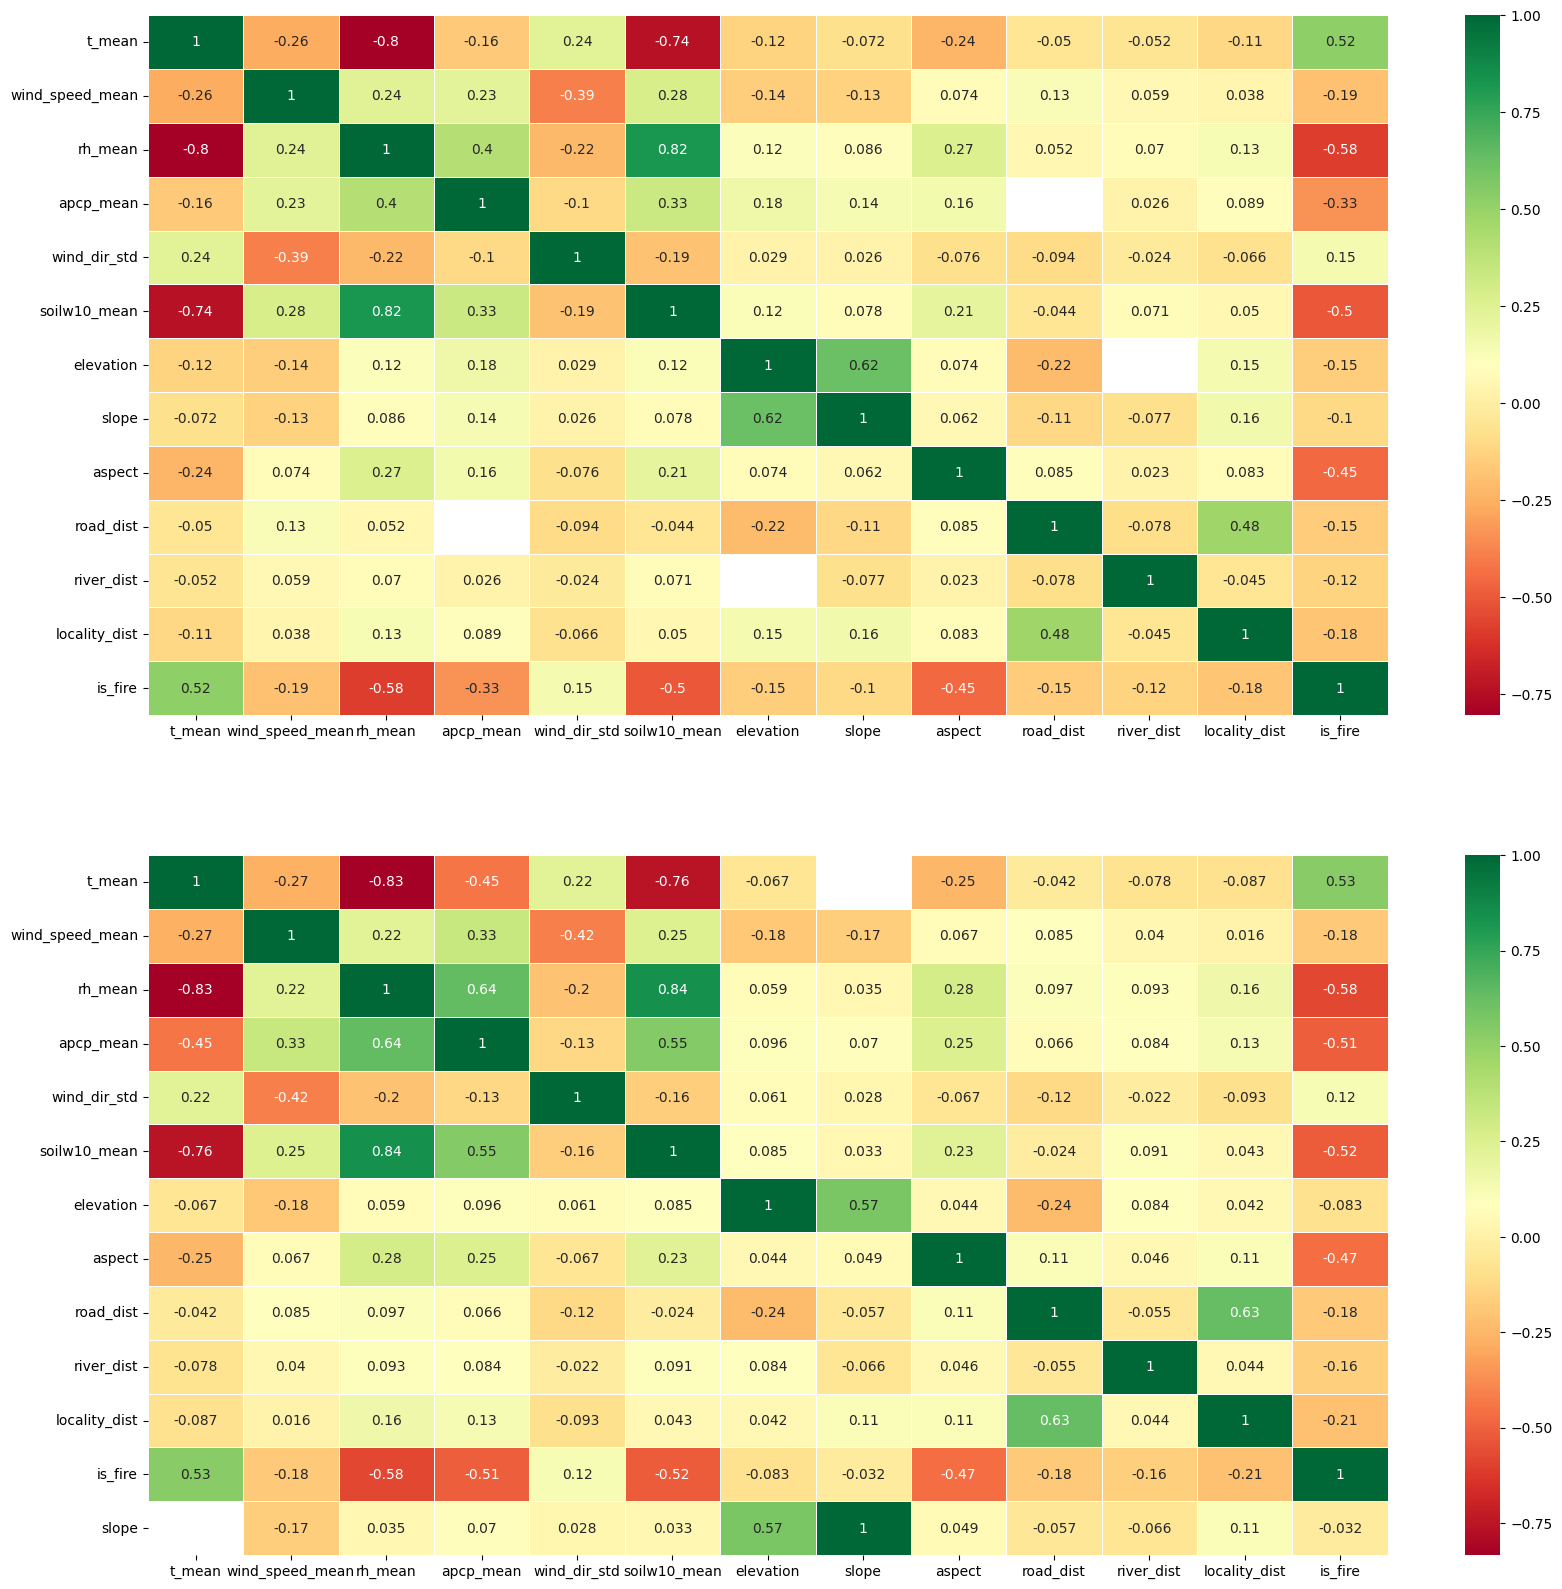

In [18]:
# correlation matrix (with pvalue considered)
fig = plt.figure(figsize=(20, 20))
ax = fig.subplots(2, 1)
pearson_m = pd.DataFrame(pearson_corr_d)
spearman_m = pd.DataFrame(spearman_corr_d)
print(pearson_m.shape, spearman_m.shape)
sns.heatmap(pearson_m, ax=ax[0], linewidths=0.5, cmap='RdYlGn', annot=True,)
sns.heatmap(spearman_m, ax=ax[1], linewidths=0.5, cmap='RdYlGn', annot=True,)
fig.savefig("out.png")

In [19]:
pearson_nan = pearson_m[pearson_m.is_fire.isnull()].index.to_list()
spearman_nan = spearman_m[spearman_m.is_fire.isnull()].index.to_list()
# pearson_m.loc[pearson_nan].index, spearman_m.loc[spearman_nan].index
pearson_nan, spearman_nan

([], [])

In [20]:
# c1 = features_dropped.corr(method="pearson")
pearson_m.is_fire.abs().nlargest(30)

is_fire           1.00
rh_mean           0.58
t_mean            0.52
soilw10_mean      0.50
aspect            0.45
apcp_mean         0.33
wind_speed_mean   0.19
locality_dist     0.18
wind_dir_std      0.15
road_dist         0.15
elevation         0.15
river_dist        0.12
slope             0.10
Name: is_fire, dtype: float64

In [21]:
# c2 = features_dropped.corr(method="spearman")
spearman_m.is_fire.abs().nlargest(30)

is_fire           1.00
rh_mean           0.58
t_mean            0.53
soilw10_mean      0.52
apcp_mean         0.51
aspect            0.47
locality_dist     0.21
road_dist         0.18
wind_speed_mean   0.18
river_dist        0.16
wind_dir_std      0.12
elevation         0.08
slope             0.03
Name: is_fire, dtype: float64

In [22]:
# # include_factors = [
# #     "apcp_mean", "rh_min", "wind_speed_min", "wind_dir_std", "t_std",
# #     "soilw10_mean", "tmpgr10_mean", 
# #     # "soilw40_mean",  #"tmpgr40_mean", 
# #     # "soilw100_mean", 
# #     # "soilw200_mean",
# #     "elevation", "slope", "locality_dist", "river_dist", "road_dist",
# # ]
# # # "tmpgr100_mean",

# base_factors = [
#     "apcp_mean", "rh_mean",
#     "t_mean", "wind_speed_mean", "wind_dir_std", "aspect",
#     "elevation", "slope", "locality_dist", "river_dist", "road_dist",
    
# ]
# include_factors = base_factors + [
#     # "rh_mean",
#     # "t_mean",
#     # "rh_min", 
#     # "rh_max",
#     # "rh_mode_num",
#     # "t_max",
#     # "tmax_mean",
#     # "tmax_mode_num",
#     # "tmin_mean",
#     # "soilw10_mean",
#     # "soilw10_min",
#     # "soilw10_max",
#     # "soilw10_mode_num",
#     # "tmpgr10_mean",
#     # "tmpgr10_min",
#     # "tmpgr10_max",
#     # "tmpgr10_mode_num",
# ]
# print(len(include_factors), include_factors,)

In [23]:
train_ds

,t_mean,wind_speed_mean,rh_mean,apcp_mean,wind_dir_std,soilw10_mean,elevation,slope,aspect,road_dist,river_dist,locality_dist,is_fire
0,-1.89,-0.05,1.20,0.15,-0.53,1.53,1.48,-0.05,-0.58,-0.09,-0.09,-0.33,0
1,-1.75,1.73,1.21,0.91,-0.65,1.41,-0.86,0.89,1.29,0.96,-0.37,-0.82,0
2,-1.79,1.67,1.17,0.28,-0.55,1.17,-0.42,-0.79,0.92,0.99,0.84,0.62,0
3,-1.40,1.40,1.23,0.79,-0.51,1.76,0.10,-0.58,0.02,-0.12,-0.04,-0.34,0
4,-2.17,1.06,1.22,0.70,0.37,0.46,-0.60,-0.73,0.15,2.62,-0.14,-0.07,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18303,-0.65,2.01,0.54,-0.32,-0.65,0.73,-0.30,0.04,-0.54,-0.82,2.23,-0.41,1
18304,-0.96,-1.08,0.04,-0.62,1.28,0.03,0.03,-0.18,-0.16,-0.94,-0.06,-1.05,1
18305,-1.44,-1.39,0.45,-0.60,1.84,0.81,0.87,-0.54,0.08,-0.32,0.81,-0.64,0
18306,-1.30,-0.43,0.64,-0.60,2.16,0.68,-0.51,-0.44,-0.22,-0.67,0.51,-0.16,1


In [24]:
# VIF (for features_ds)
features_ds = train_ds.loc[:, ~train_ds.columns.isin(["is_fire"])].join(train_dataset.vegetation_type)
VIF = pd.DataFrame()
VIF["feature"] = list(features_ds.columns)
VIF["VIF"] = [variance_inflation_factor(features_ds.values, i) for i in range(features_ds.shape[1])] 
VIF

,feature,VIF
0,t_mean,3.41
1,wind_speed_mean,1.38
2,rh_mean,5.08
3,apcp_mean,1.43
4,wind_dir_std,1.22
5,soilw10_mean,3.44
6,elevation,1.82
7,slope,1.67
8,aspect,1.09
9,road_dist,1.50


In [25]:
train_dataset.index, features_ds.index

(RangeIndex(start=0, stop=18308, step=1),
 RangeIndex(start=0, stop=18308, step=1))

In [26]:
ds_to_write = features_ds.join(train_dataset.event_date).join(train_dataset.is_fire)
print(ds_to_write.isnull().sum().sum(), ds_to_write.index)
ds_to_write.head(5)

0 RangeIndex(start=0, stop=18308, step=1)


,t_mean,wind_speed_mean,rh_mean,apcp_mean,wind_dir_std,soilw10_mean,elevation,slope,aspect,road_dist,river_dist,locality_dist,vegetation_type,event_date,is_fire
0,-1.89,-0.05,1.20,0.15,-0.53,1.53,1.48,-0.05,-0.58,-0.09,-0.09,-0.33,18,2015-03-01,0
1,-1.75,1.73,1.21,0.91,-0.65,1.41,-0.86,0.89,1.29,0.96,-0.37,-0.82,15,2015-03-01,0
2,-1.79,1.67,1.17,0.28,-0.55,1.17,-0.42,-0.79,0.92,0.99,0.84,0.62,11,2015-03-01,0
3,-1.40,1.40,1.23,0.79,-0.51,1.76,0.10,-0.58,0.02,-0.12,-0.04,-0.34,11,2015-03-01,0
4,-2.17,1.06,1.22,0.70,0.37,0.46,-0.60,-0.73,0.15,2.62,-0.14,-0.07,18,2015-03-01,0


In [27]:
# gr = sns.pairplot(train_dataset)
# gr.fig.savefig("out1.png")
# train_ds.columns

# {'SOILW40': 'Влажность почвы (в слое 10-40см), %',
#  'SOILW200': 'Влажность почвы (в слое 100-200см), %',
#  'TMIN': 'Минимальная температура, °С',
#  'SNOD': 'Глубина снега, м',
#  'TMPGR40': 'Температура почвы (в слое 10-40см), °С',
#  'T': 'Температура, °С',
#  'DATE': 'Дата',
#  'WIND_SPEED': 'Скорость ветра, м/c',
#  'TMPGR100': 'Температура почвы (в слое 40-100см), °С',
#  'LAT': 'Широта, °',
#  'TMPGR10': 'Температура почвы (в слое 0-10см), °С',
#  'LON': 'Долгота, °',
#  'TMAX': 'Максимальная температура, °С',
#  'RH': 'Относительная влажность, %',
#  'APCP': 'Количество осадков, кг/м2',
#  'TIME': 'Время',
#  'WIND_DIR': 'Направление ветра, °',
#  'TMPGR200': 'Температура почвы (в слое 100-200см), °С',
#  'SOILW10': 'Влажность почвы (в слое 0-10см), %',
#  'SOILW100': 'Влажность почвы (в слое 40-100см), %'}

In [28]:
# write file
write_path = project_files + "train_data/"
if not os.path.exists(write_path):
    os.mkdir(write_path)
ds_to_write.to_csv(write_path + "dataset.csv", sep=";")